In [1]:
import random
import networkx as nx
from torch_geometric.utils import from_networkx
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import NeighborSampler
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

## base


In [2]:
def sample_neighbors_dfs(graph, node, num_samples, visited=None):
    if visited is None:
        visited = set()
    visited.add(node)

    neighbors = list(graph.neighbors(node))
    random.shuffle(neighbors)

    samples = []
    for neighbor in neighbors:
        if len(samples) >= num_samples:
            break
        if neighbor not in visited:
            visited.add(neighbor)
            samples.append(neighbor)
            additional_samples = sample_neighbors_dfs(
                graph, neighbor, num_samples - len(samples), visited)
            samples.extend(additional_samples)
    return samples[:num_samples]


def sample_neighbors_bfs(graph, node, num_samples, visited=None):
    if visited is None:
        visited = set()
    visited.add(node)

    neighbors = list(graph.neighbors(node))
    random.shuffle(neighbors)

    samples = []
    for neighbor in neighbors:
        if len(samples) >= num_samples:
            break
        if neighbor not in visited:
            samples.append(neighbor)
            visited.add(neighbor)

    if len(samples) < num_samples:
        for neighbor in samples:
            additional_samples = sample_neighbors_bfs(
                graph, neighbor, num_samples - len(samples), visited)
            samples.extend(additional_samples)
            if len(samples) >= num_samples:
                break
    # print(samples)
    return samples[:num_samples]

BFS Sampling: [2, 3, 0, 4]
DFS Sampling: [2, 4, 5, 6]


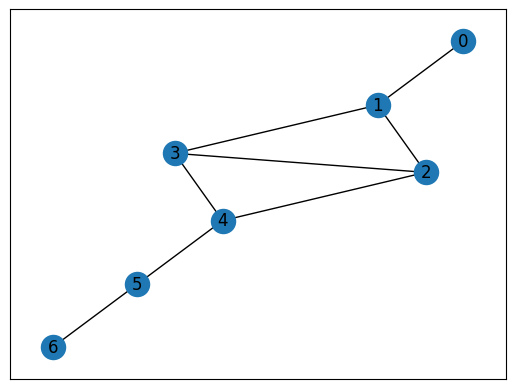

In [3]:
graph = nx.Graph()
graph.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3),
                     (3, 4), (4, 2), (4, 5), (5, 6)])
pos = nx.kamada_kawai_layout(graph)
nx.draw_networkx(graph, pos=pos)
data = from_networkx(graph)

# initial node
sampling_node = 1
# sample num
threshold = 4
sample_bfs = sample_neighbors_bfs(graph, sampling_node, threshold)
sample_dfs = sample_neighbors_dfs(graph, sampling_node, threshold)
print("BFS Sampling:", sample_bfs)
print("DFS Sampling:", sample_dfs)

## Graphsage(with dfs)


In [4]:
class GraphSAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels, graph, threshold):
        super(GraphSAGEConv, self).__init__(aggr='mean')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        # self.num_samples = num_samples
        self.graph = graph

    def forward(self, x):
        edge_index = []

        for node in range(x.size(0)):
            sampled_neighbors = sample_neighbors_dfs(
                self.graph, node, threshold)
            sampled_edges = [(node, neighbor)
                             for neighbor in sampled_neighbors]
            edge_index.extend(sampled_edges)

        edge_index = torch.tensor(
            edge_index, dtype=torch.long).t().contiguous()
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return self.lin(aggr_out)

In [5]:
num_nodes = len(graph.nodes)
in_channels = 3
out_channels = 3
node_features = torch.randn(num_nodes, 3)  # random 3 node feature dim
model = GraphSAGEConv(in_channels, out_channels, graph, threshold)
output = model(node_features)
print(output)

tensor([[-0.5063,  0.8836,  0.1516],
        [-0.4403,  0.6639,  0.0127],
        [-0.5719,  0.7786,  0.0818],
        [-1.0449,  0.8000, -0.0555],
        [-0.4266,  0.4324, -0.3027],
        [-1.0531,  0.6417, -0.3245],
        [-1.4893, -0.0906, -1.4134]], grad_fn=<AddmmBackward0>)


## 可能的动态采样


In [9]:
def dynamic_sampler(edge_index, node_idx, size=5, max_depth=2):

    sampler = NeighborSampler(
        edge_index, sizes=[size], node_idx=node_idx, batch_size=1)

    for batch_size, n_id, adjs in sampler:
        # if num_neighbor enough sample neighbors
        if len(n_id)-1 >= size:
            yield batch_size, n_id, adjs
            continue

        # if num_neighbor not enough sample neighbors's neighbor(next hop)
        if max_depth > 0:
            neighbor_adj_lists = []
            for neighbor in n_id.tolist()[1:]:
                new_neighbors = np.array(edge_index[1][np.where(
                    edge_index[0] == neighbor)], dtype=np.int32)
                if len(new_neighbors) > 0:
                    neighbor_adj_lists.append(torch.tensor(
                        [[neighbor] * len(new_neighbors), new_neighbors], dtype=torch.long))
            if len(neighbor_adj_lists) > 0:
                adj = torch.cat(neighbor_adj_lists, dim=1)
                adj = adj.to_sparse()
            else:
                adj = None

            for _, next_n_id, next_adjs in dynamic_sampler(
                    edge_index, n_id, size=size, max_depth=max_depth-1):
                # update batch_size
                next_batch_size = len(next_n_id)
                batch_size = torch.tensor([next_batch_size], dtype=torch.long)
                yield batch_size, next_n_id, next_adjs

                n_samples = next_batch_size
                for adj in next_adjs:
                    n_samples += adj.size(1)
                    if n_samples >= size:
                        break

                if n_samples >= size:
                    break

        else:
            yield batch_size, n_id, adjs


sampler = dynamic_sampler(edge_index=data.edge_index,
                          node_idx=torch.tensor([2]), size=4)
for batch_size, n_id, adjs in sampler:
    print("batch_size:", batch_size)
    print("n_id:", n_id)
    print(adjs)

batch_size: tensor([4])
n_id: tensor([2, 1, 3, 4])
EdgeIndex(edge_index=tensor([[1, 2, 3],
        [0, 0, 0]]), e_id=tensor([ 2,  8, 10]), size=(4, 1))
